In [1]:
import torch; torch.manual_seed(0)
import torch.nn.functional as F
from torch.distributions import constraints

import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import torch.utils
import torch.distributions
import torchvision
import tsfresh
import copy
import json
import time
import os
import random
import numpy as np
import pandas as  pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
from torch.distributions import Categorical

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# Import data
X = np.genfromtxt('Data_FF/X_v3.csv', delimiter=',')
Targets = np.genfromtxt('Data_FF/Targets_v3.csv', delimiter=',')

input_scaler = MinMaxScaler()
input_scaler.fit(X)
X_scaled = input_scaler.transform(X)
output_scaler = MinMaxScaler()
output_scaler.fit(Targets)
Targets_scaled = output_scaler.transform(Targets)
SEED = 6

X_scaled, X_val_scaled, Targets_scaled, Targets_val_scaled = train_test_split(
    X_scaled, Targets_scaled,
    test_size = 0.2,
    random_state = SEED
)

X_val_scaled, X_test_scaled, Targets_val_scaled, Targets_test_scaled = train_test_split(
    X_val_scaled, Targets_val_scaled,
    test_size = 0.5,
    random_state = SEED
)

print('Total data size:', len(X), ', NaN in X:', np.any(np.isnan(X_scaled)), ', NaN in Target:', np.any(np.isnan(Targets_scaled))) 
print('Training data size:', X_scaled.shape, Targets_scaled.shape)
print('Validation data size:', X_val_scaled.shape, Targets_val_scaled.shape) 
print('Test data size:', X_test_scaled.shape, Targets_test_scaled.shape)

mdn_train_dataset = TensorDataset(torch.tensor(Targets_scaled).float(), torch.tensor(X_scaled).float())
mdn_val_dataset = TensorDataset(torch.tensor(Targets_val_scaled).float(), torch.tensor(X_val_scaled).float())
mdn_test_dataset = TensorDataset(torch.tensor(Targets_test_scaled).float(), torch.tensor(X_test_scaled).float())

mdn_train_loader = DataLoader(mdn_train_dataset, batch_size=250, shuffle=False)
mdn_val_loader = DataLoader(mdn_val_dataset, batch_size=250, shuffle=False)
mdn_test_loader = DataLoader(mdn_test_dataset, batch_size=250, shuffle=False)

Total data size: 3848 , NaN in X: False , NaN in Target: False
Training data size: (3078, 5) (3078, 101)
Validation data size: (385, 5) (385, 101)
Test data size: (385, 5) (385, 101)


## Mixture Density Networks

In [3]:
# Input size is 101
class MDN(nn.Module):
    def __init__(self, num_gaussians, in_features=101, out_features=5):
        super(MDN, self).__init__()
        
        self.in_features, self.out_features, self.num_gaussians = in_features, out_features, num_gaussians
        #'''
        self.shared_layers = nn.Sequential(
            nn.Linear(in_features, 150),
            nn.SiLU(),
            nn.Linear(150, 240),
            nn.SiLU(),
            nn.Linear(240, 300),
            nn.SiLU(),
            nn.Linear(300, 300),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(300, 150),
            nn.Tanh()
        )
        
        self.pi = nn.Sequential(
            nn.Linear(150, num_gaussians),
            nn.Softmax(dim=1)
        )
        self.sigma = nn.Linear(150, out_features * num_gaussians)
        self.mu = nn.Linear(150, out_features * num_gaussians)
    
    def forward(self, y):
        y = self.shared_layers(y)
        pi = self.pi(y)
        sigma = torch.exp(self.sigma(y))
        sigma = sigma.view(-1, self.num_gaussians, self.out_features)
        mu = self.mu(y)
        mu = mu.view(-1, self.num_gaussians, self.out_features)
        return pi, sigma, mu

$y$ [batch size, input size], $x$ [batch size, output size]

$\Pi$ [batch size, number of distribution], $\sum^{K}_{k=1}\Pi_{k} = 1$, $K$ is the number of distribution

$\sigma$ [batch size, number of distribution, output size], $\mu$ [batch size, number of distribution, output size]

Probability Distribution Function: $\mathrm{p}(\boldsymbol{x} \mid \boldsymbol{y})=\sum_{\mathrm{k}=1}^{\mathrm{K}} \Pi_{\mathrm{k}} (\boldsymbol{y})\phi_{\mathrm{k}}(\boldsymbol{x}, \sigma_{k}, \mu_{k})$

$\phi(\boldsymbol{x}, \sigma_{k}, \mu_{k}) = \sum_{c}\phi_{\mathrm{k}}(\boldsymbol{x}, \sigma_{k}, \mu_{k}) = \left(\frac{1}{\sigma_k \sqrt{2 \pi}} e^{-\frac{1}{2}\left(\frac{x-\mu_k}{\sigma_k}\right)^2}\right)^{c}$, c is the number of output feature (5 in this case)

$\operatorname{loss}(x \mid y)=-\log \left[\sum_k^K \Pi_k(\boldsymbol{y}) \phi\left(x, \sigma_k, \mu_k\right)\right]$

In [4]:
# Training

# Parameter initialization in transfer learning
def change_model_weights(model, old_model, tl):
    index = []
    for name, para in model.named_parameters():
        if 'shared_layers' in name:
            #para.requires_grad = False
            index.append(int(name.split(".")[1]))

    # hidden layers
    for i in list(set(index)):
        model.shared_layers[i].weight.data = old_model.shared_layers[i].weight.data
        model.shared_layers[i].bias.data = old_model.shared_layers[i].bias.data

    # output layers
    model.pi[0].weight.data = torch.zeros(model.pi[0].weight.data.shape)

    model.pi[0].bias.data = torch.zeros(model.pi[0].bias.data.shape)

    c = old_model.sigma.weight.data
    if tl == 1:
        l = random.randint(0, c.shape[0]/5-1)
        n = [5*l+i for i in range(5)]
    elif tl == 2:
        n = list(range(5))
    for i in range(5):
        c = torch.cat((c, old_model.sigma.weight.data[n[i]].reshape(1, 150)), dim=0)
    model.sigma.weight.data = c

    d = old_model.sigma.bias.data
    if tl == 1:
        l = random.randint(0, d.shape[0]/5-1)
        n = [5*l+i for i in range(5)]
    elif tl == 2:
        n = list(range(5))
    for i in range(5):
        d = torch.cat((d, old_model.sigma.bias.data[n[i]].reshape(1)), dim=0)
    model.sigma.bias.data = d

    e = old_model.mu.weight.data
    if tl == 1:
        l = random.randint(0, e.shape[0]/5-1)
        n = [5*l+i for i in range(5)]
    elif tl == 2:
        n = list(range(5))
    for i in range(5):
        e = torch.cat((e, old_model.mu.weight.data[n[i]].reshape(1, 150)), dim=0)
    model.mu.weight.data = e

    f = old_model.mu.bias.data
    if tl == 1:
        l = random.randint(0, f.shape[0]/5-1)
        n = [5*l+i for i in range(5)]
    elif tl == 2:
        n = list(range(5))
    for i in range(5):
        f = torch.cat((f, old_model.mu.bias.data[n[i]].reshape(1)), dim=0)
    model.mu.bias.data = f

    return model

def gaussian_distribution(x, mu, sigma):
    target = x.unsqueeze(1).expand_as(mu)
    ret = torch.exp(-0.5 * ((target - mu) / sigma)**2) / (sigma * np.sqrt(2.0*np.pi))
    ret = torch.prod(ret, dim=2)
    return ret

def mdn_loss_fn(pi, sigma, mu, x):
    result = gaussian_distribution(x, mu+1e-5, sigma) * pi
    result = torch.sum(result, dim=1)
    result = -torch.log(result+1e-5)
    return torch.mean(result)

def train_mdn(t_loader, v_loader, n_epochs, early_stop, model, old_model):
    """
    This is a brief description of the function.

    Parameters:
    - param1: Training data loader 
    - param2: Validation data loader
    - param3: Number of training epochs
    - param4: Threshold of early stopping
    - param5: Model to be trained (Eg: MDN(num_gaussians=a), a is number of distribution)
    - param6: Previous model used for transfer learning (None / model name)

    Returns:
    A list of training loss at each epoch, trained model, best validation loss and corresponding training loss
    """

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    early_stop_counter = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val, best_train = 1000.0, 0
    history = dict(train=[], val=[])

    # Perform transfer learning if an old model is input
    if old_model is not None:
        # tl should be 1 or 2, represent initialization method
        tl = 1
        model = change_model_weights(model, old_model, tl)

    for epoch in range(1, n_epochs + 1):
        # Training
        model = model.train()
        train_losses = []
        for batch_idx, (y, x) in enumerate(t_loader):
            optimizer.zero_grad()
            pi_variable, sigma_variable, mu_variable = model(y)
            loss = mdn_loss_fn(pi_variable, sigma_variable, mu_variable, x)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # Validation
        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for batch_idx, (y, x) in enumerate(v_loader):
                pi_variable, sigma_variable, mu_variable = model(y)
                loss = mdn_loss_fn(pi_variable, sigma_variable, mu_variable, x)
                val_losses.append(loss.item())

        val_loss = np.mean(val_losses)
        train_loss = np.mean(train_losses)
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        #if epoch%10 == 0:
        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
        
        # Early Stop
        if val_loss < best_val:
            best_val = val_loss
            best_train = train_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        elif val_loss > train_loss and val_loss >= best_val:
            if early_stop is not None:
                early_stop_counter += 1
                if early_stop_counter > early_stop:
                    print(f'Early stopping at epoch {epoch}')
                    break

    print(f'Best Loss {best_val}')
    model.load_state_dict(best_model_wts)
    return history, model.eval(), best_val, best_train

#'''
# train single model
old_model = torch.load('models/MDN/1.pth')
a = 2
# early stop: with ae:500, without ae:600
history, model, bv, bt = train_mdn(mdn_train_loader, mdn_val_loader, 1000, 600, MDN(num_gaussians=a), old_model)
torch.save(model, str(a)+'.pth')
#'''

'''
# mixture component number from 1 to 10 without tl
t, v =[], []
folder_name = 'MDNs/'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
for a in range(1, 11):
    print(a)
    # early stop: with ae:500, without ae:600
    history, model, bv, bt = train_mdn(mdn_train_loader, mdn_val_loader, 1000, 600, MDN(num_gaussians=a), None)
    torch.save(model, folder_name + str(a)+'.pth')
    print(bv, '\n')
    t.append(bt)    
    v.append(bv)
'''

'''
# mixture component number from 1 to 10 with tl
t1, v1 =[], []
folder_name = 'TL_MDNs/'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
for a in range(1, 11):
    print(a)
    if a == 1:
        history, model, bv, bt = train_mdn(mdn_train_loader, mdn_val_loader, 1000, 600, MDN(num_gaussians=a), None)
        torch.save(model, folder_name + str(a) + '.pth')
        print(bv, '\n')
    else:
        # early stop: with ae:60, without ae:150
        history, model, bv, bt = train_mdn(mdn_train_loader, mdn_val_loader, 600, 150, MDN(num_gaussians=a), model)
        torch.save(model, folder_name + str(a) + '.pth')
        print(bv, '\n')
    
    t1.append(bt)    
    v1.append(bv)
'''

Epoch 1: train loss -5.601705642846914 val loss -6.309952259063721
Epoch 2: train loss -7.7597563083355245 val loss -7.1728315353393555
Epoch 3: train loss -9.088947002704327 val loss -7.473750591278076
Epoch 4: train loss -9.529212144704966 val loss -7.535867929458618
Epoch 5: train loss -9.472324664776142 val loss -7.630152940750122
Epoch 6: train loss -9.459543228149414 val loss -7.633625030517578
Epoch 7: train loss -9.71317041837252 val loss -7.68389630317688
Epoch 8: train loss -9.830482262831469 val loss -7.349645376205444
Epoch 9: train loss -9.758659509512094 val loss -7.528716802597046
Epoch 10: train loss -9.627999525803785 val loss -7.741663932800293
Epoch 11: train loss -9.63812439258282 val loss -7.85189414024353
Epoch 12: train loss -9.657477378845215 val loss -7.406829595565796
Epoch 13: train loss -9.639983837421124 val loss -7.577345609664917
Epoch 14: train loss -9.571549635667067 val loss -6.9722349643707275
Epoch 15: train loss -9.583655577439528 val loss -7.638171

"\n# mixture component number from 1 to 10 with tl\nt1, v1 =[], []\nfolder_name = 'TL_MDNs/'\nif not os.path.exists(folder_name):\n    os.makedirs(folder_name)\nfor a in range(1, 11):\n    print(a)\n    if a == 1:\n        history, model, bv, bt = train_mdn(mdn_train_loader, mdn_val_loader, 1000, 600, MDN(num_gaussians=a), None)\n        torch.save(model, folder_name + str(a) + '.pth')\n        print(bv, '\n')\n    else:\n        # early stop: with ae:60, without ae:150\n        history, model, bv, bt = train_mdn(mdn_train_loader, mdn_val_loader, 600, 150, MDN(num_gaussians=a), model)\n        torch.save(model, folder_name + str(a) + '.pth')\n        print(bv, '\n')\n    \n    t1.append(bt)    \n    v1.append(bv)\n"

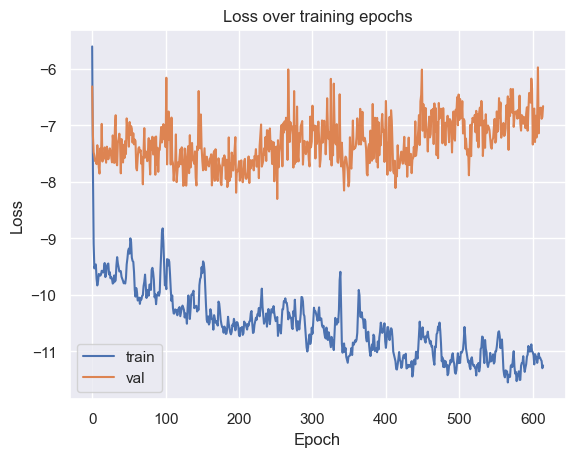

In [5]:
# Plot training loss of a single model
sns.set()
ax = plt.figure().gca()
ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])
plt.title('Loss over training epochs')
plt.show()

## Test with Forward Model

In [6]:
# Forward Model
class CNN(nn.Module):
    def __init__(self, input_size=5, output_size=101, num_channels1=32, num_channels2=64, kernel_size=3, dropout=0.2):
        super(CNN, self).__init__()
        self.input_size, self.output_size, self.num_channels1, self.num_channels2, self.kernel_size, self.dropout = input_size, output_size, num_channels1, num_channels2, kernel_size, dropout
        self.tcn1 = nn.Sequential(
            nn.Conv1d(input_size, 32, kernel_size, stride=1, padding=1),
            nn.SiLU(inplace=True))
        self.tcn2 = nn.Sequential(    
            nn.Conv1d(32, 64, kernel_size, stride=1, padding=1),
            nn.SiLU(inplace=True))
        self.tcn3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size, stride=1, padding=1),
            nn.SiLU(inplace=True))
        self.tcn4 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size, stride=1, padding=1),
            nn.SiLU(inplace=True))
        self.tcn5 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size, stride=1, padding=1),
            nn.SiLU(inplace=True),
            nn.Dropout(dropout))
            
        self.f1 = nn.Linear(256, 182)
        self.f2 = nn.Linear(182, 101)
        self.silu = nn.SiLU()

    def forward(self, x):
        x = x.reshape(x.shape[0], x.shape[1], 1)
        x = self.tcn1(x)
        x = self.tcn2(x)
        x = self.tcn3(x)
        x = self.tcn4(x)
        x = self.tcn5(x)
        x = x.reshape(x.shape[0], x.shape[1])
        x = self.silu(self.f1(x))
        x = self.f2(x)
        return x

Ground Truth: [0.484, 0.715, 0.616, 0.534, 0.366]
Prediction  10 : [0.538, 0.697, 0.634, 0.502, 0.45]  Mixing Coefficients: 0.471  RMSE: 0.0471
Prediction  3 : [0.505, 0.718, 0.625, 0.513, 0.408]  Mixing Coefficients: 0.459  RMSE: 0.0432
Prediction  1 : [0.591, 0.654, 0.664, 0.469, 0.504]  Mixing Coefficients: 0.025  RMSE: 0.0522


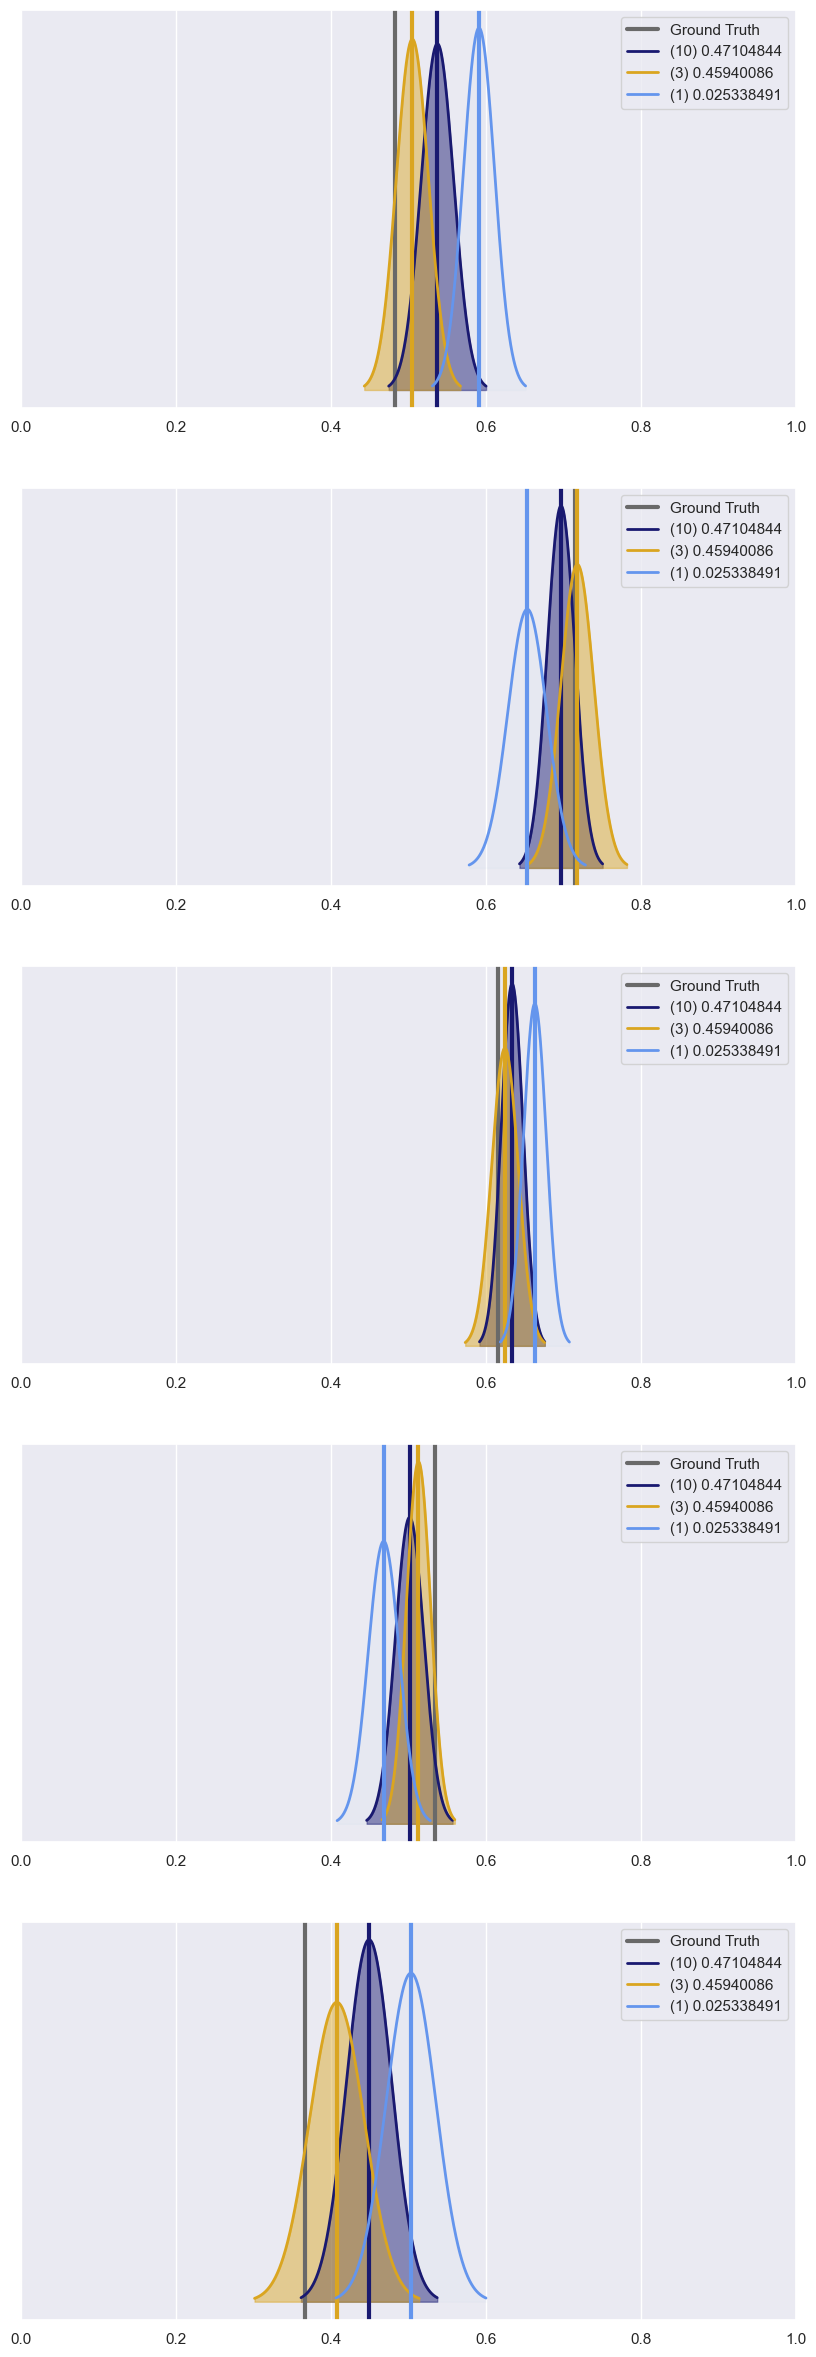

In [7]:
# Each subplot represents PDFs of each parameter
def plot_distributions(index, num, path):
    """
    This is a brief description of the function.

    Parameters:
    - param1: Index of test sample (0-384)
    - param2: Number of distributions (0-10)
    - param3: Folder path of model used for test

    Returns:
    The function doesn't return anything
    """

    mod = torch.load('models/forward_models/cnn.pth')
    colors = ['CornflowerBlue', 'SeaGreen', 'GoldEnrod', 'IndianRed', 'DarkOrchid', 'DarkKhaki', 'PaleVioletRed', 'Chocolate', 'LightSeaGreen', 'MidnightBlue']
    model = torch.load(path+str(num)+'.pth') 

    p, s, m, o = [], [], [], []
    for batch_idx, (y, x) in enumerate(mdn_test_loader):
        for i in y:
            pi_variable, sigma_variable, mu_variable = model(i.unsqueeze(0))
            p.append(pi_variable.detach().numpy()[0])
            s.append(sigma_variable.detach().numpy()[0])
            m.append(mu_variable.detach().numpy()[0])

    new_p = copy.deepcopy(p[index]).tolist()
    max_number, max_index = [], []
    for _ in range(num):
        number = max(new_p)
        idx = new_p.index(number)     
        new_p[idx] = 0
        max_number.append(number)
        max_index.append(idx)

    def calc_rmse(actual, predict): 
        squared_diff = (actual - predict) ** 2
        mse = squared_diff.mean()
        rmse = np.sqrt(mse)
        return rmse

    original = mdn_test_dataset[index][0].tolist() 
    lst, err = [], [0 for i in range(len(max_index))]
    for k in max_index:
        pre = mod(torch.from_numpy(m[index][k]).unsqueeze(0)).squeeze().tolist()
        rmse = calc_rmse(np.array(original), np.array(pre)) 
        err[k] = rmse
        # Filter out solutions that are far away from true data
        if rmse > 0.065:
            lst.append(k)
        
    sns.set()
    fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(10, 30))
    for i in range(5):
        xmin, xmax = 0, 1
        axs[i].axvline(mdn_test_dataset[index][1][i], linewidth=3, label='Ground Truth', color='DimGray')
        for j in max_index:
            if (j not in lst) or (j==max_index[0]):
                if m[index][j][i] > xmax:
                    xmax = m[index][j][i]+0.05
                if m[index][j][i] < xmin:
                    xmin = m[index][j][i]-0.05
                dist = torch.distributions.Normal(loc=torch.tensor(m[index][j][i]), scale=torch.tensor(s[index][j][i]))
                x = torch.linspace(m[index][j][i] - 3*s[index][j][i], m[index][j][i] + 3*s[index][j][i], 1000)
                pdf = torch.exp(dist.log_prob(x))
                axs[i].plot(x.numpy(), pdf.numpy(), label='('+str(j+1)+') '+str(p[index][j]), linewidth=2, color=colors[j])
                axs[i].fill_between(x.numpy(), pdf.numpy(), alpha=p[index][j], color=colors[j])
                axs[i].axvline(m[index][j][i], linewidth=3, color=colors[j])
                axs[i].axis(xmin=xmin, xmax=xmax)
                axs[i].set_yticks([])
                axs[i].legend()
                #print('m:', m[n][j][i], 's:', s[n][j][i])

    print('Ground Truth:', [round(num, 3) for num in mdn_test_dataset[index][1].tolist()])
    for j in max_index:
        if j not in lst or j==max_index[0]:
            print('Prediction ', j+1, ':', [round(num, 3) for num in m[index][j]], ' Mixing Coefficients:', round(p[index][j], 3), ' RMSE:', round(err[j], 4))

    plt.show()

plot_distributions(239, 10, 'models/MDN_TL_1/')

True Parameters: 
 tensor([0.1830, 0.2366, 0.1401, 0.7397, 0.7905], dtype=torch.float64)
Index: 384 , Number of Distribution: 10
Predicted Parameters:
tensor([0.1395, 0.2006, 0.1254, 0.7380, 0.7514])
tensor([0.1413, 0.1839, 0.1551, 0.7498, 0.7764])
tensor([0.1827, 0.2434, 0.1520, 0.7283, 0.8108])
tensor([0.3000, 0.2612, 0.1776, 0.7432, 1.0239])
tensor([0.1213, 0.2511, 0.0459, 0.7465, 0.7549])
tensor([0.2194, 0.2664, 0.1398, 0.6972, 0.8410])
tensor([0.1990, 0.2525, 0.1677, 0.7276, 0.8446])
tensor([0.2071, 0.2694, 0.1200, 0.7192, 0.8420])
tensor([0.2303, 0.2058, 0.1471, 0.7628, 0.8143])
tensor([0.1996, 0.2318, 0.1520, 0.7200, 0.8183])


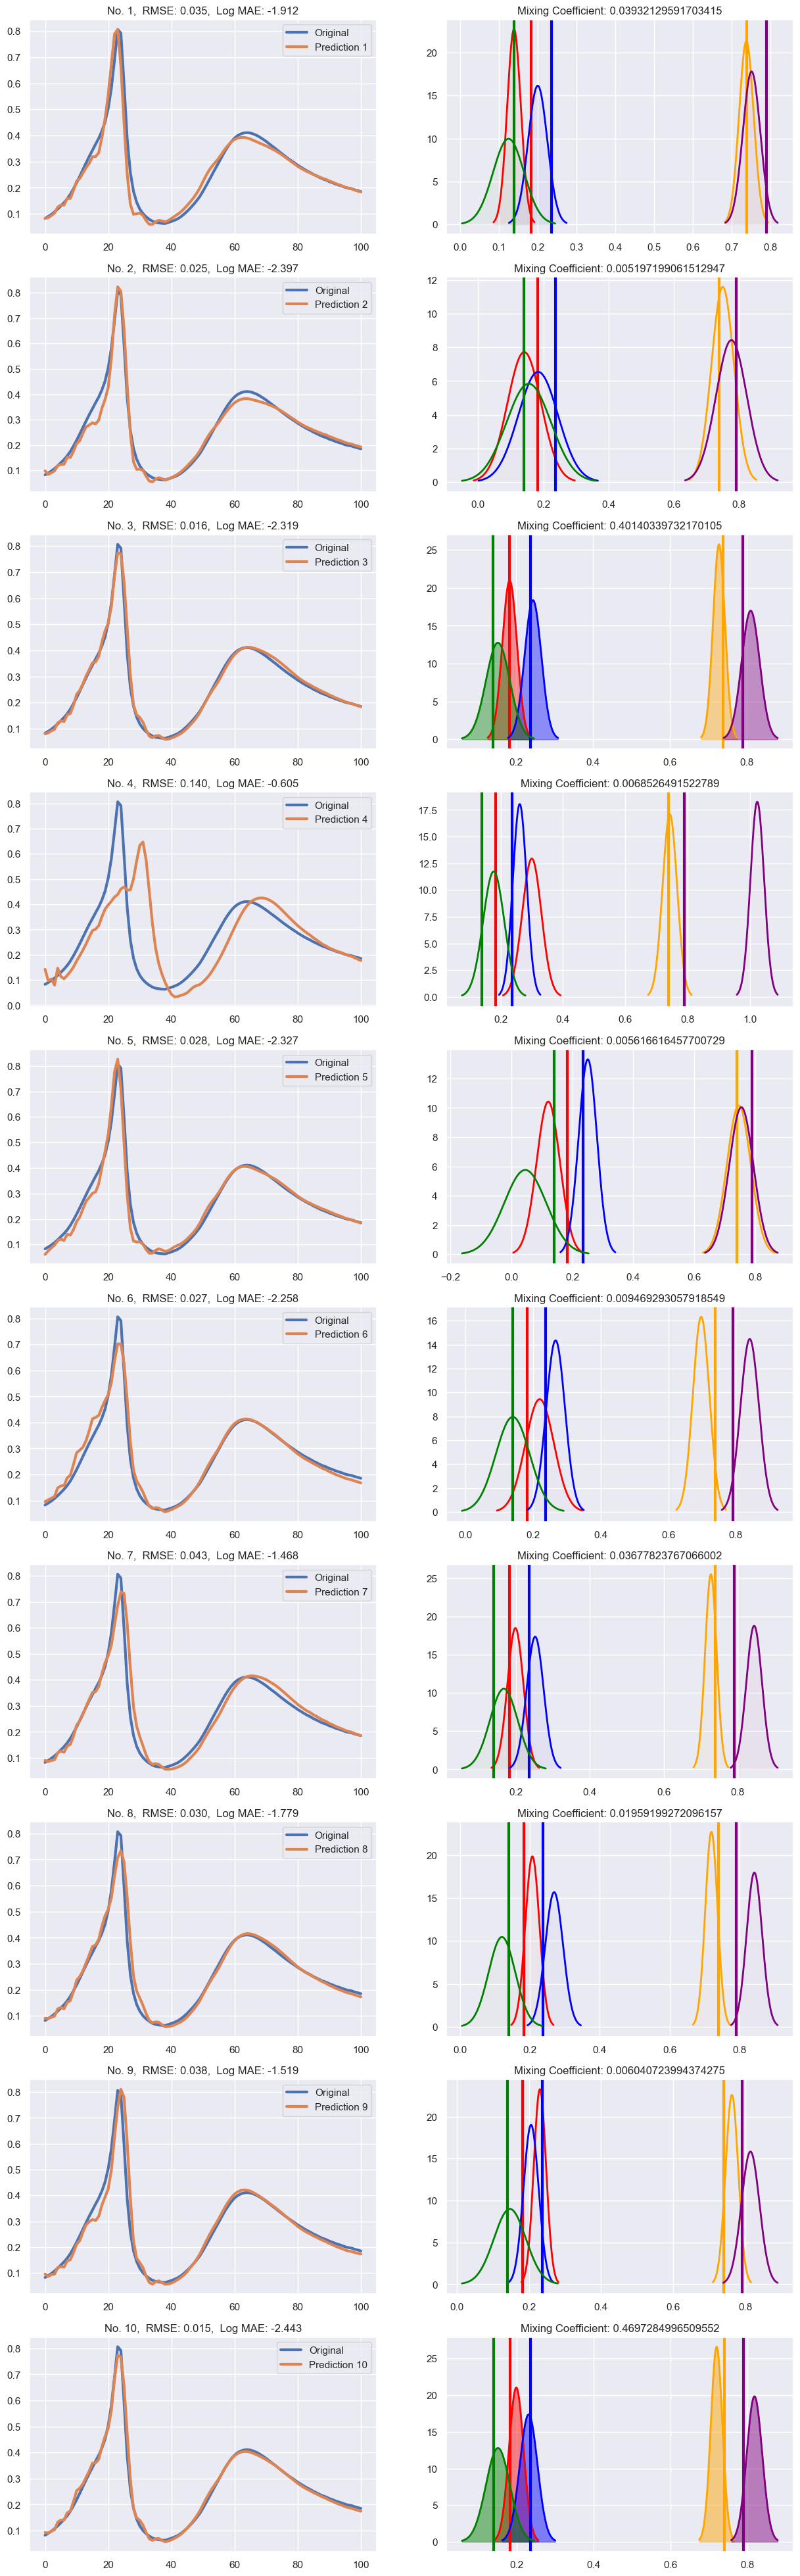

In [8]:
# Each row represents one possible solution 
def plot_one_sample(index, num, path):
    """
    This is a brief description of the function.

    Parameters:
    - param1: Index of test sample (0-384)
    - param2: Number of distributions (0-10)
    - param3: Folder path of model used for test

    Returns:
    The function doesn't return anything
    """

    model = torch.load(path+str(num)+'.pth')       
    p, s, m, o, d101 = [], [], [], [], []
    for batch_idx, (y, x) in enumerate(mdn_test_loader):
        for i in y:
            pi_variable, sigma_variable, mu_variable = model(i.unsqueeze(0))
            p.append(pi_variable.detach().numpy()[0])
            s.append(sigma_variable.detach().numpy()[0])
            m.append(mu_variable.detach().numpy()[0])

    mod = torch.load('models/forward_models/cnn.pth')
    for i in m[index]:
        pre = mod(torch.from_numpy(i).unsqueeze(0)).squeeze().tolist()
        d101.append(pre)

    if 'AE' in path:
        ori = np.array(data_test_scaled[index])
    else:
        ori = mdn_test_dataset[index][0].detach().numpy()

    def calc_loss(actual, predict): 
        squared_diff = (actual - predict) ** 2
        mse = squared_diff.mean()
        rmse = np.sqrt(mse)

        absolute_errors = [abs(actual[i] - predict[i]) for i in range(len(actual))]
        max_absolute_error = max(absolute_errors)
        log_mae = np.log(max_absolute_error)
        return rmse, log_mae
    
    print('True Parameters:', '\n', torch.from_numpy(X_test_scaled[index]))
    #print(torch.from_numpy(Targets_test_scaled[index]))
    print('Index:', index, ', Number of Distribution:', num)
    fig, axs = plt.subplots(nrows=num, ncols=2, figsize=(15, 5*num))
    colour = ['red', 'blue', 'green', 'orange', 'purple']
    print('Predicted Parameters:')
    for i in range(num):
        print(torch.from_numpy(m[index][i]))
        rmse, log_mae = calc_loss(ori, np.array(d101[i]))
        pi = p[index][i]
        axs[i, 0].set_title(f'No. {i+1},  RMSE: {rmse:.3f},  Log MAE: {log_mae:.3f}')
        axs[i, 0].plot(ori, label='Original', linewidth=3)
        axs[i, 0].plot(d101[i], label='Prediction '+str(i+1), linewidth=3)
        axs[i, 0].legend()
        axs[i, 1].set_title(f'Mixing Coefficient: {pi}')
        for j in range(5):
            dist = torch.distributions.Normal(loc=torch.tensor(m[index][i][j]), scale=torch.tensor(s[index][i][j]))
            x = torch.linspace(m[index][i][j] - 3*s[index][i][j], m[index][i][j] + 3*s[index][i][j], 1000)
            pdf = torch.exp(dist.log_prob(x))
            axs[i, 1].plot(x.numpy(), pdf.numpy(), linewidth=2, color=colour[j])
            axs[i, 1].fill_between(x.numpy(), pdf.numpy(), alpha=pi, color=colour[j])
            axs[i, 1].axvline(mdn_test_dataset[index][1][j], linewidth=3, color=colour[j])

    plt.show()

l = [373, 314, 315, 331, 344, 248, 239, 228, 215, 139, 138]
plot_one_sample(384, 10, 'models/MDN_TL_1/')

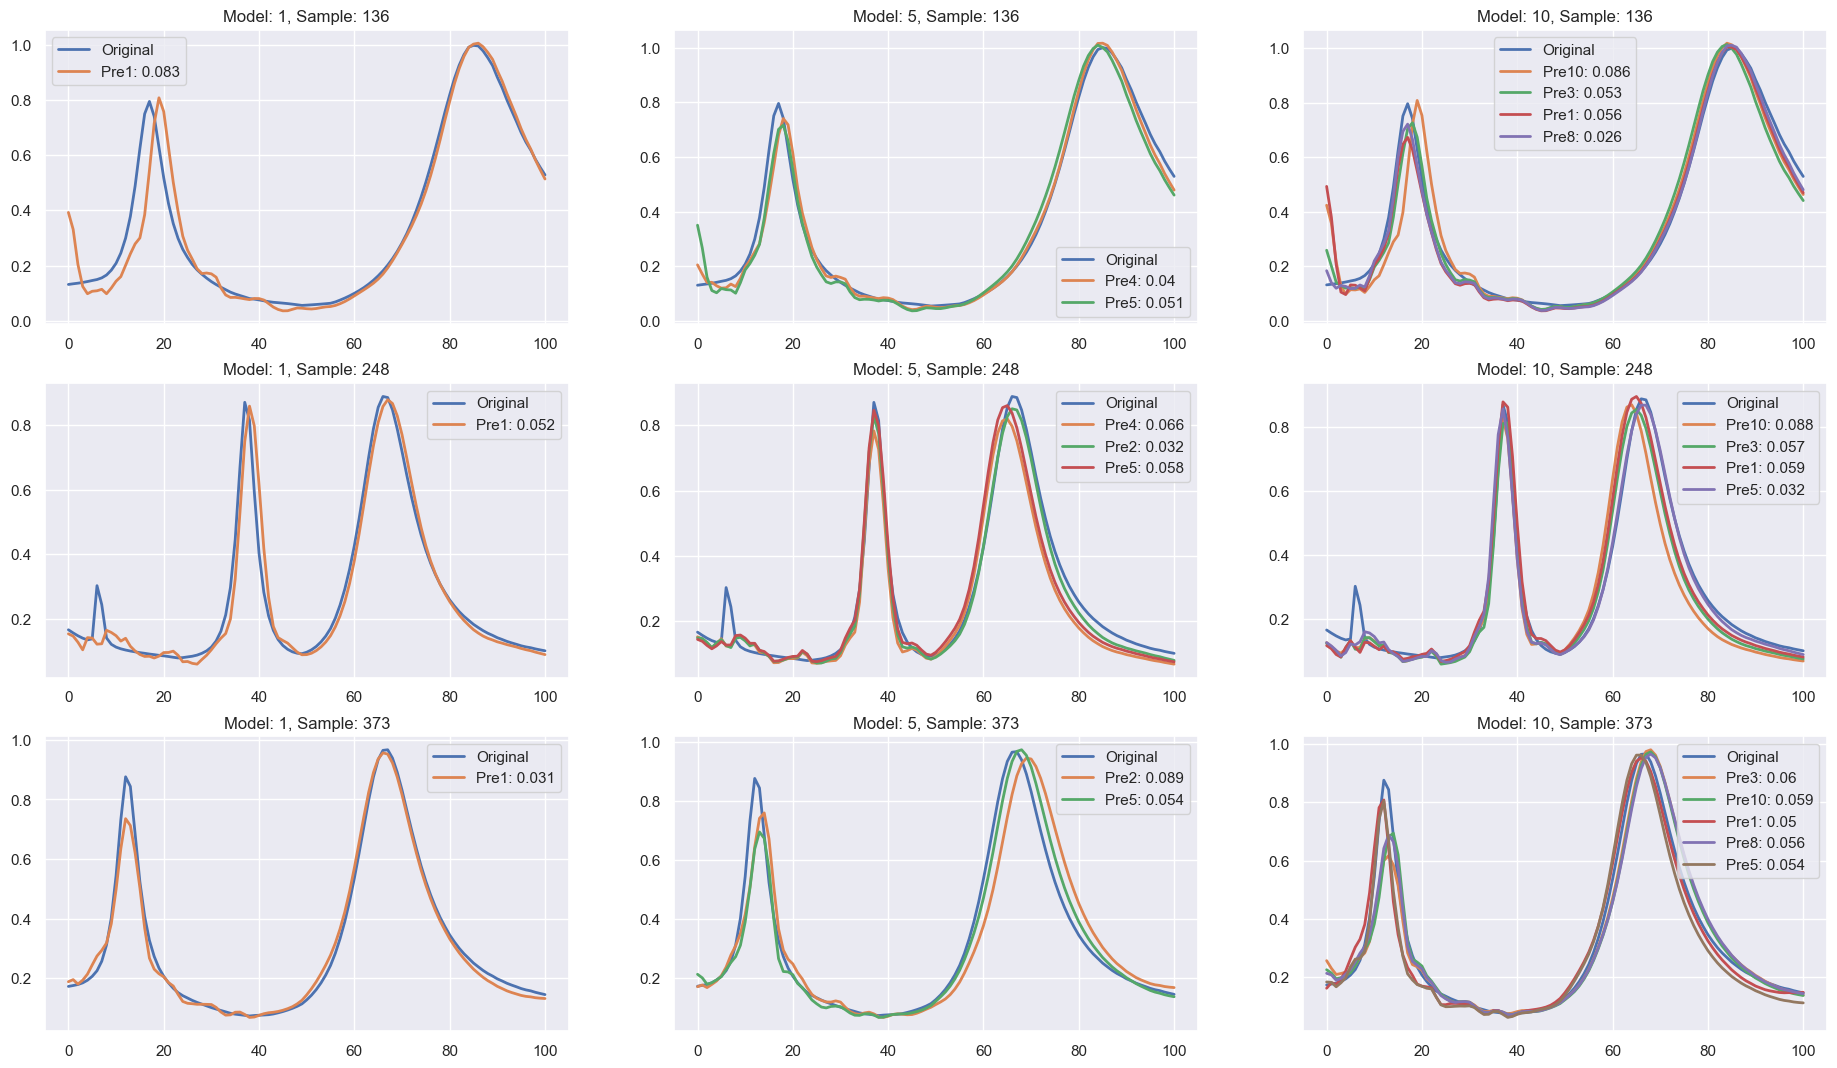

In [9]:
# Plot three test samples for model 1, 5, 10
def plot_3(samples, path):
    """
    This is a brief description of the function.

    Parameters:
    - param1: List contains three index of test sample (0-384, Eg: [138, 248, 373])
    - param2: Folder path of model used for test

    Returns:
    The function doesn't return anything
    """

    mod = torch.load('models/forward_models/cnn.pth')
    p, s, m, A = [], [], [], False 
    sns.set()
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(23, 13))
    for i in range(3):
        for j in range(3):
            if i == 0: 
                model_num, l = 1, 1
            elif i == 1: 
                model_num, l = 5, 5
            elif i == 2: 
                model_num, l = 10, 10

            model = torch.load(path + str(model_num) + '.pth')

            pi_variable, sigma_variable, mu_variable = model(mdn_test_dataset[samples[j]][0].unsqueeze(0))
            for z in range(len(pi_variable[0])):
                p.append(pi_variable[0][z].detach().numpy())
                s.append(sigma_variable[0][z].detach().numpy())
                m.append(mu_variable[0][z].detach().numpy())

            new_p = copy.deepcopy(p)
            max_number, max_index = [], []
            for _ in range(l):
                number = max(new_p)
                index = new_p.index(number)     
                new_p[index] = 0
                max_number.append(number)
                max_index.append(index)

            def calc_rmse(actual, predict): 
                squared_diff = (actual - predict) ** 2
                mse = squared_diff.mean()
                rmse = np.sqrt(mse)
                return rmse

            axs[j, i].set_title(f'Model: {model_num}, Sample: {samples[j]}')
            original = mdn_test_dataset[samples[j]][0].tolist()
            axs[j, i].plot(original, label='Original', linewidth=2)
            for k in max_index:
                pre = mod(torch.from_numpy(m[k]).unsqueeze(0)).squeeze().tolist()
                rmse = calc_rmse(np.array(original), np.array(pre))
                if (rmse < 0.06 and np.all(m[k] > 0)) or k == max_index[0]:
                    axs[j, i].plot(pre, label='Pre'+str(k+1)+': '+str(round(rmse, 3)), linewidth=2)
                    #print('Model:', model_num, ', Sample:', samples[j], ', Predicted Parameters '+str(k+1)+':', torch.from_numpy(m[k]))
                    #print('Model:', model_num, ', Sample:', samples[j], ', Predicted Data '+str(k+1)+':', torch.tensor(pre))

            axs[j, i].legend()
            p, s, m = [], [], []

    plt.show()

plot_3([136, 248, 373], 'models/MDN_TL_1/')

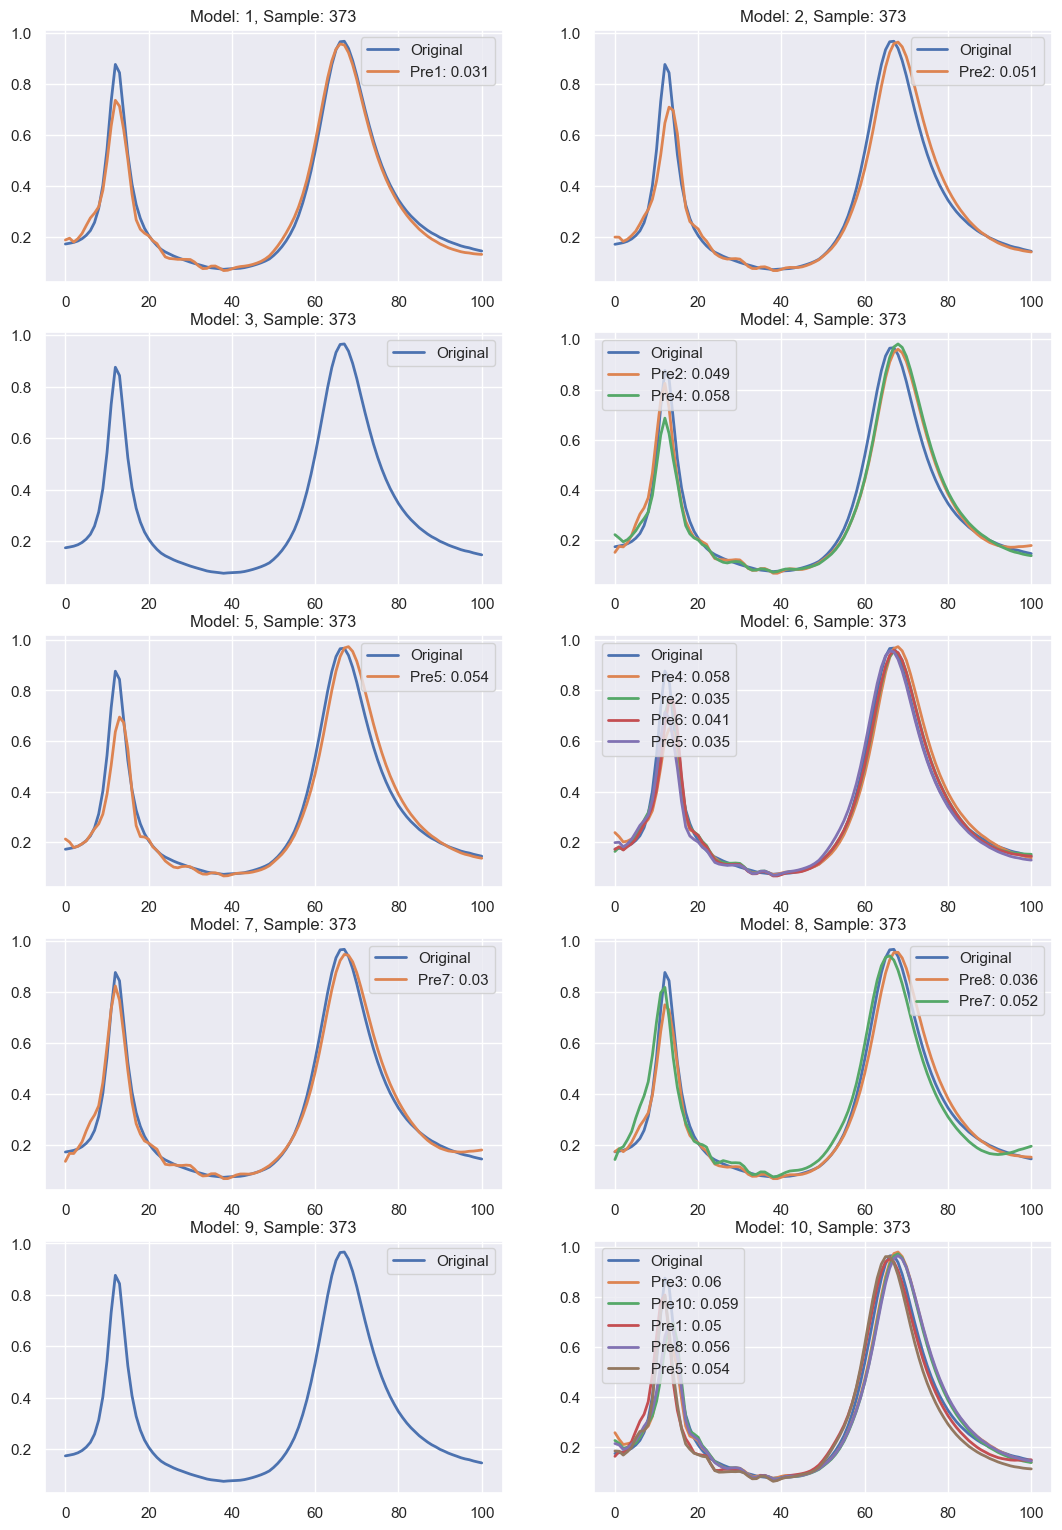

In [10]:
# One sample for all models
def plot_all_models(index, path):
    """
    This is a brief description of the function.

    Parameters:
    - param1: List contains three index of test sample (0-384, Eg: [138, 248, 373])
    - param2: Folder path of model used for test

    Returns:
    The function doesn't return anything
    """

    mod = torch.load('models/forward_models/cnn.pth')
    samples = index
    p, s, m, = [], [], [] 
    sns.set()
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(13, 19))
    for i in range(5):
        for j in range(2):
            model_num = i*2+j+1
            model = torch.load(path + str(model_num) + '.pth')

            pi_variable, sigma_variable, mu_variable = model(mdn_test_dataset[samples][0].unsqueeze(0))
            for z in range(len(pi_variable[0])):
                p.append(pi_variable[0][z].detach().numpy())
                s.append(sigma_variable[0][z].detach().numpy())
                m.append(mu_variable[0][z].detach().numpy())

            new_p = copy.deepcopy(p)
            max_number, max_index = [], []
            l = model_num
            for _ in range(l):
                number = max(new_p)
                index = new_p.index(number)     
                new_p[index] = 0
                max_number.append(number)
                max_index.append(index)

            def calc_rmse(actual, predict): 
                squared_diff = (actual - predict) ** 2
                mse = squared_diff.mean()
                rmse = np.sqrt(mse)
                return rmse

            axs[i, j].set_title(f'Model: {model_num}, Sample: {samples}')
            original = mdn_test_dataset[samples][0].tolist()
            axs[i, j].plot(original, label='Original', linewidth=2)
            for k in max_index:
                pre = mod(torch.from_numpy(m[k]).unsqueeze(0)).squeeze().tolist()
                rmse = calc_rmse(np.array(original), np.array(pre))
                # Filter out outputs that are not close to true data
                if rmse < 0.06:
                    axs[i, j].plot(pre, label='Pre'+str(k+1)+': '+str(round(rmse, 3)), linewidth=2)
            axs[i, j].legend()
            p, s, m = [], [], []

    plt.show()

plot_all_models(373, 'models/MDN_TL_1/')

Number of Distribution: 10 , Mean RMSE: 0.06135971207186008 , Mean Log MAE: -1.7355963718065797


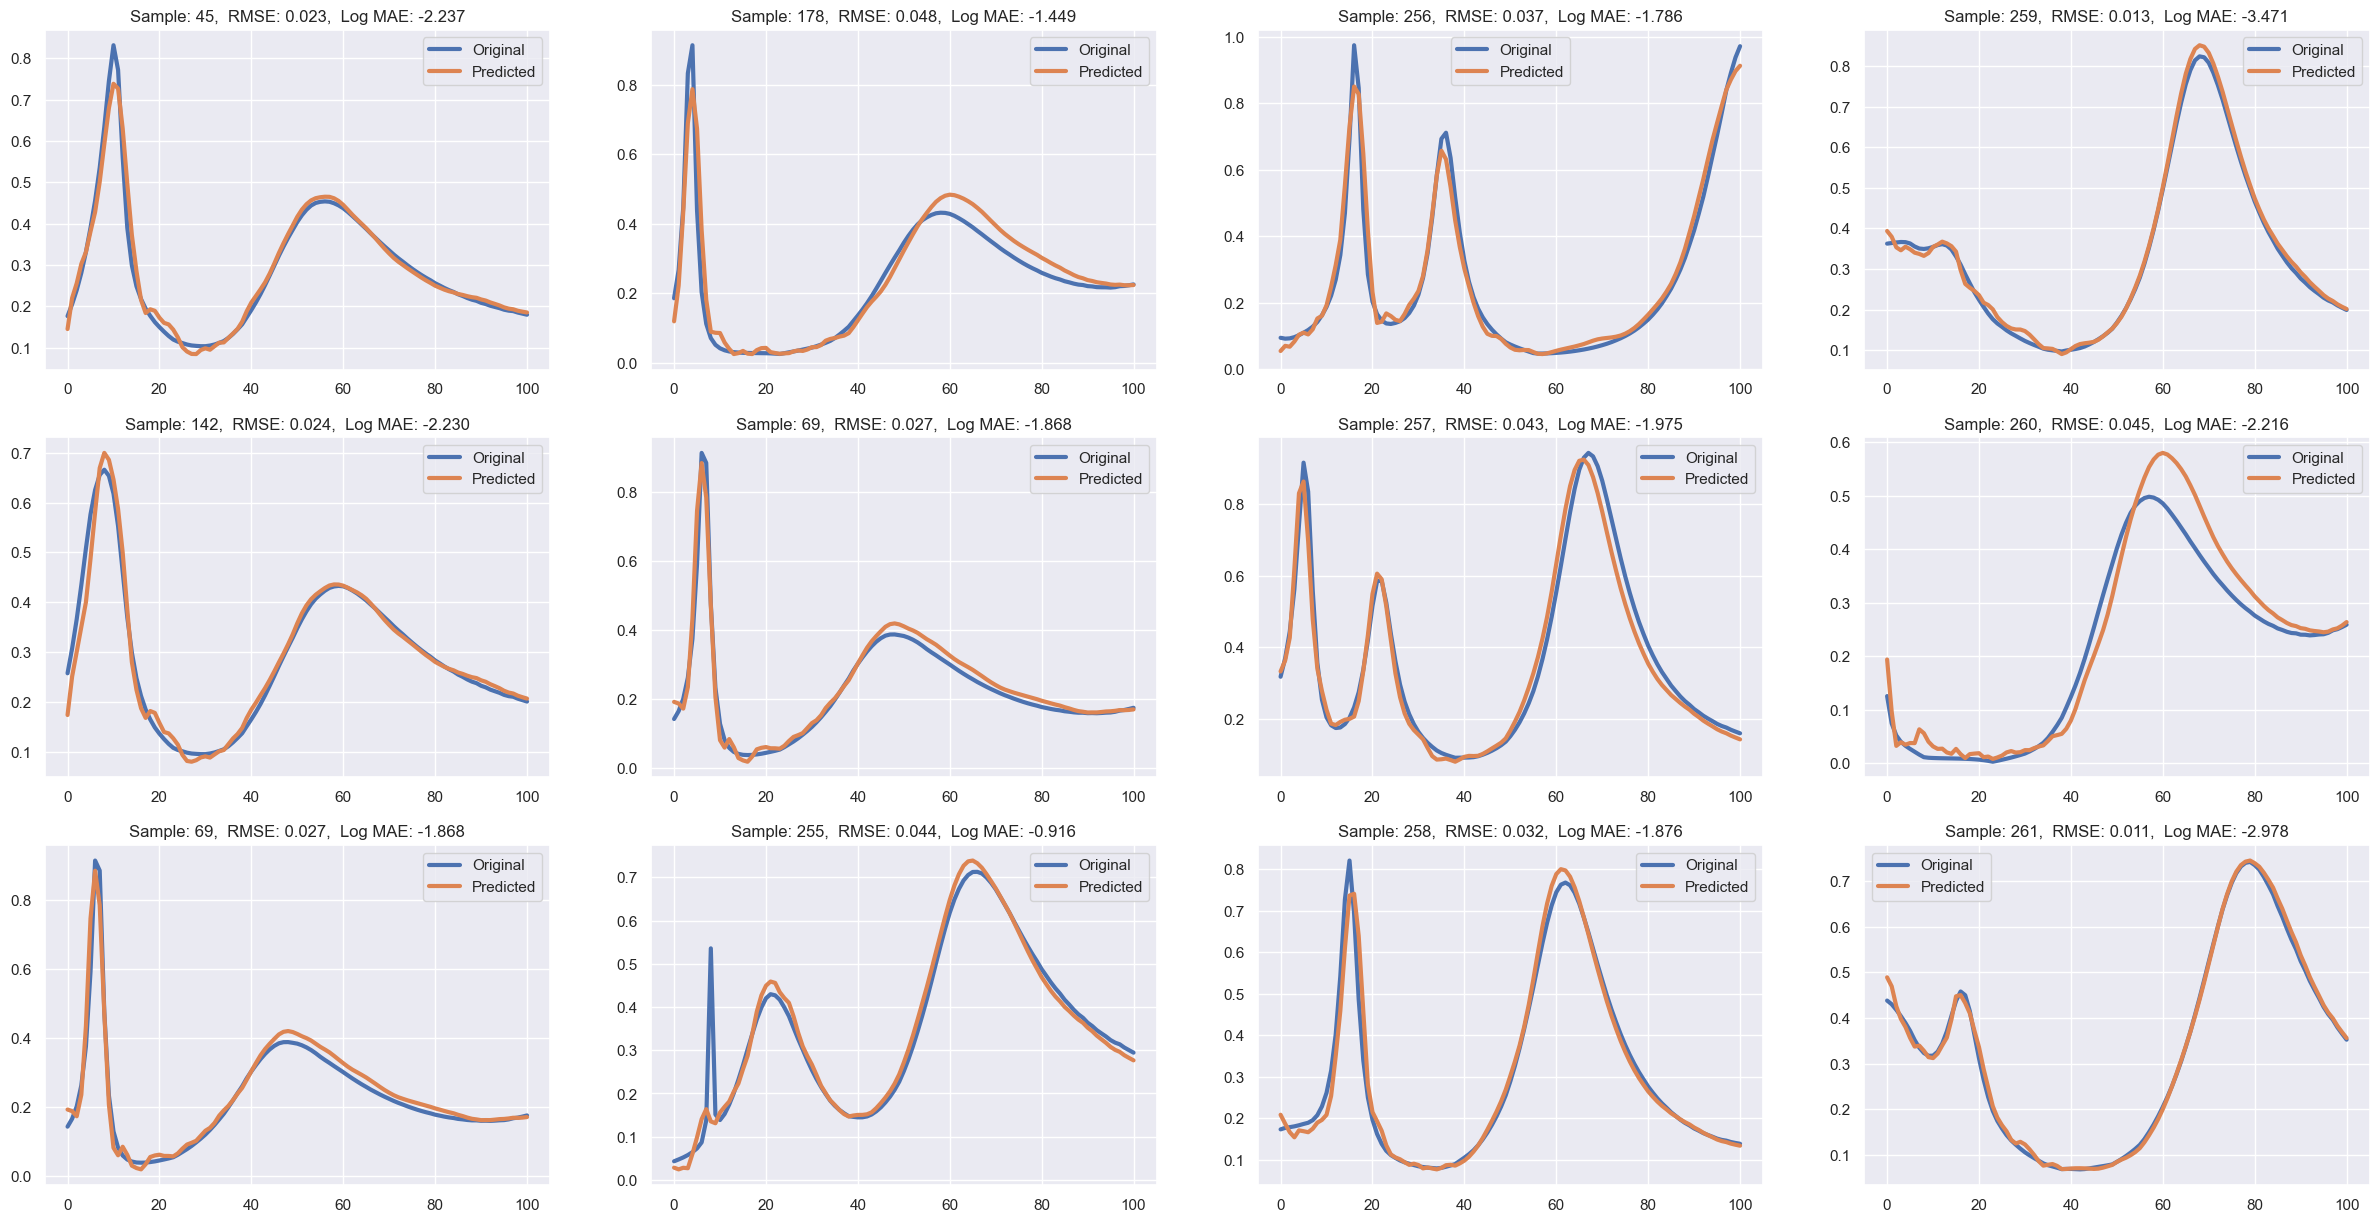

In [11]:
# Plot multiple samples using the same model
def plot_samples(l, num, path):
    """
    This is a brief description of the function.

    Parameters:
    - param1: List contains ten index of test sample (0-384)
    - param2: Number of distributions (0-10)
    - param3: Folder path of model used for test

    Returns:
    The function doesn't return anything
    """
    model = torch.load(path+str(num)+'.pth')       
    p, s, m, o = [], [], [], []
    for batch_idx, (y, x) in enumerate(mdn_test_loader):
        for i in y:
            pi_variable, sigma_variable, mu_variable = model(i.unsqueeze(0))
            p.append(pi_variable.detach().numpy()[0])
            s.append(sigma_variable.detach().numpy()[0])
            m.append(mu_variable.detach().numpy()[0])

    d5, d101 = [], []
    mod = torch.load('models/forward_models/cnn.pth')
    for i in range(len(m)):
        j = list(p[i]).index(max(list(p[i])))
        d5.append(list(m[i][j]))
        pre = mod(torch.from_numpy(m[i][j]).unsqueeze(0)).squeeze().tolist()
        d101.append(pre)
        
    ori = []
    for i in mdn_test_dataset:
        ori.append(i[0].detach().numpy())

    def calc_rmse(actual, predict): 
        squared_diff = (actual - predict) ** 2
        mse = squared_diff.mean()
        rmse = np.sqrt(mse)
        return rmse

    def calc_log_mae(actual, predict):
        absolute_errors = [abs(actual[i] - predict[i]) for i in range(len(actual))]
        max_absolute_error = max(absolute_errors)
        log_mae = np.log(max_absolute_error)
        return log_mae

    rmse = calc_rmse(np.array(ori), np.array(d101))
    log_mae = []
    for i in range(len(d101)):
        log_mae.append(calc_log_mae(ori[i], np.array(d101)[i]))
    print('Number of Distribution:', num, ', Mean RMSE:', rmse, ', Mean Log MAE:', np.mean(log_mae))

    sns.set()
    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(30, 15))
    n = 0
    for i in range(4):
        for j in range(3):
            rmse = calc_rmse(ori[l[n]], np.array(d101)[l[n]])
            log_mae = calc_log_mae(ori[l[n]], np.array(d101)[l[n]])
            axs[j, i].set_title(f'Sample: {l[n]},  RMSE: {rmse:.3f},  Log MAE: {log_mae:.3f}')
            axs[j, i].plot(ori[l[n]], label='Original', linewidth=3)
            axs[j, i].plot(np.array(d101)[l[n]], label='Predicted', linewidth=3)
            axs[j, i].legend()
            n += 1

    plt.show()

l = [45, 142, 69, 178, 69, 255, 256, 257, 258, 259, 260, 261]
plot_samples(l, 10, 'models/MDN_TL_1/')

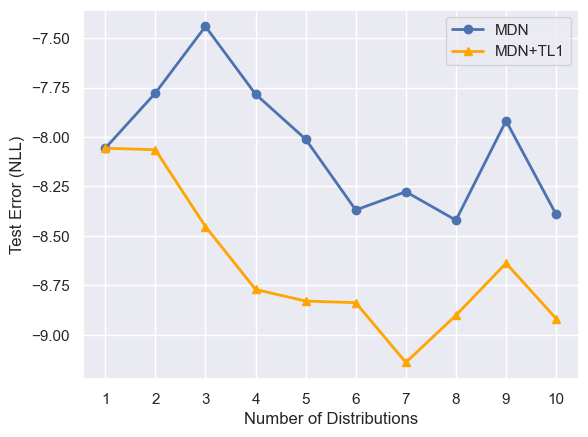

In [12]:
# Plot test nll
def gaussian_distribution(x, mu, sigma):
    target = x.unsqueeze(1).expand_as(mu)
    ret = torch.exp(-0.5 * ((target - mu) / sigma)**2) / (sigma * np.sqrt(2.0*np.pi))
    ret = torch.prod(ret, dim=2)
    return ret

def mdn_loss_fn(pi, sigma, mu, x):
    result = gaussian_distribution(x, mu+1e-5, sigma) * pi
    result = torch.sum(result, dim=1)
    result = -torch.log(result+1e-5)
    return torch.mean(result)

def test_nll(path):
    """
    This is a brief description of the function.

    Parameters:
    - param1: Folder path of models used for test

    Returns:
    The function returns a list that contains test error (NLL) of each model
    """
    test_error = []
    for num in range(1, 11):
        model = torch.load(path+str(num)+'.pth')
        err = []
        for batch_idx, (y, x) in enumerate(mdn_test_loader):
            pi_variable, sigma_variable, mu_variable = model(y)
            loss = mdn_loss_fn(pi_variable, sigma_variable, mu_variable, x)
            err.append(loss.item())
        test_error.append(np.mean(err))

    return test_error

MDN_tl_err = test_nll('models/MDN_TL_1/')
MDN_err = test_nll('models/MDN/')

ax = plt.figure().gca()
x_values = list(np.arange(1, 11))
ax.plot(MDN_err, 'o-', linewidth=2, color='b', label='MDN')
ax.plot(MDN_tl_err, '^-', linewidth=2, color='orange', label='MDN+TL1')
ax.set_ylabel('Test Error (NLL)')
ax.set_xlabel('Number of Distributions')
ax.set_xticks(np.arange(len(x_values)))
ax.set_xticklabels(x_values)
ax.legend()
plt.show()

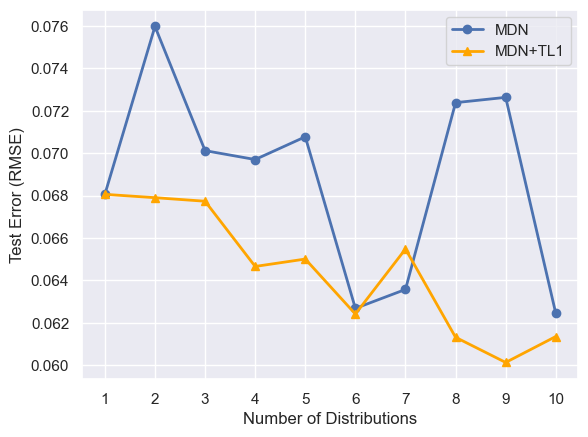

In [13]:
# Plot test rmse
def test_rmse(path, loader, dataset):
    """
    This is a brief description of the function.

    Parameters:
    - param1: Folder path of models used for test
    - param2: Test data loader (can be found in the block of import data)
    - param3: Test dataset (can be found in the block of import data)

    Returns:
    The function returns 2 lists that contains test error (rmse and mse) of each model
    """

    e1, e2 = [], []
    for a in range(1, 11):
        MDN(num_gaussians=a)
        model = torch.load(path+str(a)+'.pth')
        
        p, s, m, o = [], [], [], []
        for batch_idx, (y, x) in enumerate(loader):
            for i in y:
                pi_variable, sigma_variable, mu_variable = model(i.unsqueeze(0))
                p.append(pi_variable.detach().numpy()[0])
                s.append(sigma_variable.detach().numpy()[0])
                m.append(mu_variable.detach().numpy()[0])

        d5, d101 = [], []
        mod = torch.load('models/forward_models/cnn.pth')
        for i in range(len(m)):
            j = list(p[i]).index(max(list(p[i])))
            d5.append(list(m[i][j]))
            pre = mod(torch.from_numpy(m[i][j]).unsqueeze(0)).squeeze().tolist()
            d101.append(pre)
            
        ori = []
        for i in dataset:
            ori.append(i[0].detach().numpy())

        # calculate rmse & mse  
        squared_diff = (np.array(ori) - np.array(d101)) ** 2
        mse = squared_diff.mean()
        rmse = np.sqrt(mse)
        e1.append(rmse)
        e2.append(mse)
        #print('MSE:', rmse)

    return e1, e2

MDN_rmse, MDN_mse = test_rmse('models/MDN/', mdn_test_loader, mdn_test_dataset)
MDN_tl_rmse, MDN_tl_mse = test_rmse('models/MDN_TL_1/', mdn_test_loader, mdn_test_dataset)
ax = plt.figure().gca()
x_values = list(np.arange(1, 11))
ax.plot(MDN_rmse, 'o-', linewidth=2, color='b', label='MDN')
ax.plot(MDN_tl_rmse, '^-', linewidth=2, color='orange', label='MDN+TL1')
ax.set_ylabel('Test Error (RMSE)')
ax.set_xlabel('Number of Distributions')
ax.set_xticks(np.arange(len(x_values)))
ax.set_xticklabels(x_values)
ax.legend()
plt.show()